# Reference Online Articles
- Topic Modelling in Python with NLTK and Gensim: https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
- Topic Modeling and Latent Dirichlet Allocation (LDA) in Python: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

**Original Source**
- Evaluate Topic Models: Latent Dirichlet Allocation (LDA): https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
  - Basic LDA Model codes by the same author
    - Topic Modeling in Python: Latent Dirichlet Allocation (LDA): https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0


### Model Implementation
1. Loading Data
2. Data Cleaning
3. Phrase Modeling: Bi-grams and Tri-grams
4. Data Transformation: Corpus and Dictionary
5. Base Model
6. Hyper-parameter Tuning
7. Final model
8. Visualize Results


** **
#### Step 1: Loading Data
** **

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os

papers = pd.read_csv('/content/drive/MyDrive/CE807 Text Analytics/Assignment 2/BBC_News_Dataset.csv')
papers = papers.drop(columns=['Unnamed: 0'])
papers.head

<bound method NDFrame.head of                                             paper_title
0     Ask Jeeves tips online ad revival\n\nAsk Jeeve...
1     Pernod takeover talk lifts Domecq\n\nShares in...
2     Call centre users 'lose patience'\n\nCustomers...
3     High fuel prices hit BA's profits\n\nBritish A...
4     Rank 'set to sell off film unit'\n\nLeisure gr...
...                                                 ...
2220  Be careful how you code\n\nA new European dire...
2221  Cebit fever takes over Hanover\n\nThousands of...
2222  Losing yourself in online gaming\n\nOnline rol...
2223  US cyber security chief resigns\n\nThe man mak...
2224  BT program to beat dialler scams\n\nBT is intr...

[2225 rows x 1 columns]>

** **
#### Step 2: Data Cleaning
** **

Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data from each paper, and drop other metadata columns

In [3]:
# Remove the columns
#papers = papers.drop(columns=['id', 'title', 'abstract', 'event_type', 'pdf_name', 'year'], axis=1)

# sample only 100 papers
papers = papers.sample(100)

# Print out the first rows of papers
papers.head()

,paper_title
1439,Time to get tough on friendlies?\n\nFor an int...
1329,O'Sullivan could run in Worlds\n\nSonia O'Sull...
751,Grammys honour soul star Charles\n\nThe memory...
508,Water firm Suez in Argentina row\n\nA conflict...
1593,Laporte tinkers with team\n\nFrance coach Bern...


##### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [4]:
# Load the regular expression library 
import re

# Remove punctuation
papers['paper_text_processed'] = papers['paper_title'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

1439    time to get tough on friendlies\n\nfor an inte...
1329    o'sullivan could run in worlds\n\nsonia o'sull...
751     grammys honour soul star charles\n\nthe memory...
508     water firm suez in argentina row\n\na conflict...
1593    laporte tinkers with team\n\nfrance coach bern...
Name: paper_text_processed, dtype: object

##### Tokenize words and further clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [5]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['time', 'to', 'get', 'tough', 'on', 'friendlies', 'for', 'an', 'international', 'manager', 'friendly', 'provides', 'an', 'important', 'opportunity', 'to', 'work', 'with', 'your', 'players', 'the', 'only', 'problem', 'is', 'that', 'the', 'game', 'itself', 'can', 'often']


** **
#### Step 3: Phrase Modeling: Bigram and Trigram Models
** **

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Some examples in our example are: 'back_bumper', 'oil_leakage', 'maryland_college_park' etc.

Gensim's Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold.

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


#### Remove Stopwords, Make Bigrams and Lemmatize

The phrase models are ready. Let’s define the functions to remove the stopwords, make trigrams and lemmatization and call them sequentially.

In [7]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let's call the functions in order.

In [9]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [10]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['time', 'tough', 'friendly', 'international', 'manager', 'provide', 'important', 'opportunity', 'work', 'player', 'problem', 'game', 'often', 'farce', 'people', 'say', 'would', 'better', 'player', 'together', 'week', 'away', 'minute', 'end', 'would', 'say', 'game', 'look', 'way', 'would']


** **
#### Step 4: Data transformation: Corpus and Dictionary
** **

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [11]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


** **
#### Step 5: Base Model 
** **

We have everything required to train the base LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior (we'll use default for the base model).

chunksize controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.

passes controls how often we train the model on the entire corpus (set to 10). Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.

In [12]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

** **
The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using `lda_model.print_topics()`

In [13]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"say" + 0.014*"game" + 0.008*"market" + 0.007*"look" + '
  '0.006*"economy" + 0.006*"year" + 0.006*"set" + 0.006*"make" + '
  '0.005*"remain" + 0.005*"fall"'),
 (1,
  '0.024*"year" + 0.023*"say" + 0.012*"people" + 0.011*"game" + 0.010*"last" + '
  '0.009*"list" + 0.008*"lending" + 0.007*"music" + 0.006*"mortgage" + '
  '0.005*"part"'),
 (2,
  '0.016*"say" + 0.010*"make" + 0.009*"people" + 0.009*"search" + 0.007*"film" '
  '+ 0.007*"would" + 0.007*"get" + 0.006*"also" + 0.006*"software" + '
  '0.006*"work"'),
 (3,
  '0.015*"say" + 0.011*"arm" + 0.009*"want" + 0.009*"embargo" + 0.009*"lift" + '
  '0.008*"would" + 0.008*"yugansk" + 0.006*"eastender" + 0.006*"control" + '
  '0.006*"share"'),
 (4,
  '0.021*"say" + 0.009*"also" + 0.008*"first" + 0.008*"world" + 0.007*"profit" '
  '+ 0.007*"people" + 0.006*"take" + 0.006*"year" + 0.006*"top" + '
  '0.005*"last"'),
 (5,
  '0.020*"say" + 0.009*"first" + 0.008*"good" + 0.008*"win" + 0.008*"also" + '
  '0.007*"year" + 0.006*"last" +

#### Compute Model Perplexity and Coherence Score

Let's calculate the baseline coherence score

In [14]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.28885975502142375


** **
#### Step 6: Hyperparameter tuning
** **
First, let's differentiate between model hyperparameters and model parameters :

- `Model hyperparameters` can be thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or in our case, number of topics K

- `Model parameters` can be thought of as what the model learns during training, such as the weights for each word in a given topic.

Now that we have the baseline coherence score for the default LDA model, let's perform a series of sensitivity tests to help determine the following model hyperparameters: 
- Number of Topics (K)
- Dirichlet hyperparameter alpha: Document-Topic Density
- Dirichlet hyperparameter beta: Word-Topic Density

We'll perform these tests in sequence, one parameter at a time by keeping others constant and run them over the two difference validation corpus sets. We'll use `C_v` as our choice of metric for performance comparison 

In [15]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

Let's call the function, and iterate it over the range of topics, alpha, and beta parameter values

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('parameter_tuning_results', index=False)
    pbar.close()

  0%|          | 0/540 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
 80%|███████▉  | 430/540 [21:07<06:02,  3.29s/it]

In [33]:
# Store the parameter tuning results into an object and save into a csv file
#param_tuning = pd.DataFrame(model_results)
#param_tuning.to_csv('parameter_tuning_20.csv')
#df.to_csv('BBC_News_Dataset.csv')
#param_tuning.to_excel('parameter_tuning_20.xlsx')
pd.DataFrame(model_results)

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.246845
1,75% Corpus,2,0.01,0.31,0.258322
2,75% Corpus,2,0.01,0.61,0.245108
3,75% Corpus,2,0.01,0.91,0.245108
4,75% Corpus,2,0.01,symmetric,0.256412
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.289475
536,100% Corpus,10,asymmetric,0.31,0.338515
537,100% Corpus,10,asymmetric,0.61,0.354323
538,100% Corpus,10,asymmetric,0.91,0.336869


In [34]:
# Load the dataset from GoogleDrive
param_results_10 = pd.read_csv('/content/drive/MyDrive/CE807 Text Analytics/Assignment 2/parameter_tuning_10.csv')
param_results_10 = param_results_10.drop(columns=['Unnamed: 0'])
param_results_10.sort_values(by = 'Coherence', ascending=False)

# Best K-number topics based on coherence score
pd.DataFrame(param_results_10.groupby(['Topics'], sort=False)['Coherence', 'Alpha', 'Beta'].max()).sort_values(by = 'Coherence', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,Coherence,Alpha,Beta
Topics,,,
7,0.507301,symmetric,symmetric
9,0.480604,symmetric,symmetric
8,0.448870,symmetric,symmetric
10,0.446346,symmetric,symmetric
6,0.424928,symmetric,symmetric
5,0.315337,symmetric,symmetric
3,0.312138,symmetric,symmetric
4,0.304893,symmetric,symmetric
2,0.292904,symmetric,symmetric


In [35]:
pd.DataFrame(param_results_10[['Topics', 'Coherence', 'Alpha', 'Beta']]).sort_values(by = 'Coherence', ascending=False)

,Topics,Coherence,Alpha,Beta
438,7,0.507301,0.9099999999999999,0.9099999999999999
433,7,0.481425,0.61,0.9099999999999999
498,9,0.480604,0.9099999999999999,0.9099999999999999
157,7,0.453987,0.31,0.61
172,7,0.451548,symmetric,0.61
...,...,...,...,...
315,3,0.225362,0.9099999999999999,0.01
300,3,0.223631,0.01,0.01
320,3,0.221437,symmetric,0.01
305,3,0.221437,0.31,0.01


In [36]:
# Parameter tuning results with up to 20 topics
param_results_20 = pd.read_csv('/content/drive/MyDrive/CE807 Text Analytics/Assignment 2/parameter_tuning_20.csv')
param_results_20 = param_results_20.drop(columns=['Unnamed: 0'])
param_results_20.sort_values(by = 'Coherence', ascending=False)

# Best K-number topics based on coherence score
pd.DataFrame(param_results_20.groupby(['Topics'], sort=False)['Coherence', 'Alpha', 'Beta'].max()).sort_values(by = 'Coherence', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,Coherence,Alpha,Beta
Topics,,,
16,0.556886,symmetric,symmetric
17,0.547511,symmetric,symmetric
12,0.544328,symmetric,symmetric
13,0.542928,symmetric,symmetric
15,0.537681,symmetric,symmetric
14,0.522373,symmetric,symmetric
20,0.515205,symmetric,symmetric
18,0.514201,symmetric,symmetric
11,0.510596,symmetric,symmetric


In [37]:
pd.DataFrame(param_results_20[['Topics', 'Coherence', 'Alpha', 'Beta']]).sort_values(by = 'Coherence', ascending=False)

,Topics,Coherence,Alpha,Beta
1008,16,0.556886,0.9099999999999999,0.9099999999999999
463,17,0.547511,0.61,0.9099999999999999
318,12,0.544328,0.9099999999999999,0.9099999999999999
918,13,0.542928,0.9099999999999999,0.9099999999999999
978,15,0.537681,0.9099999999999999,0.9099999999999999
...,...,...,...,...
615,3,0.225362,0.9099999999999999,0.01
600,3,0.223631,0.01,0.01
605,3,0.221437,0.31,0.01
620,3,0.221437,symmetric,0.01


In [38]:
# Save 50 topics result as csv file and excel file format
param_results_50 = pd.read_csv('/content/drive/MyDrive/CE807 Text Analytics/Assignment 2/parameter_tuning_50.csv')
param_results_50 = param_results_50.drop(columns=['Unnamed: 0'])
param_results_50.sort_values(by = 'Coherence', ascending=False)

#pd.DataFrame(param_tuning.groupby(['Topics'], sort=False)['Coherence', 'Alpha', 'Beta'].max()).sort_values(by = 'Coherence', ascending=False)
pd.DataFrame(param_results_50[['Topics', 'Coherence', 'Alpha', 'Beta', 'Validation_Set']]).sort_values(by = 'Coherence', ascending=False).head(20)

,Topics,Coherence,Alpha,Beta,Validation_Set
2108,23,0.567858,0.31,0.9099999999999999,100% Corpus
548,20,0.533896,0.31,0.9099999999999999,75% Corpus
653,23,0.532192,symmetric,0.9099999999999999,75% Corpus
638,23,0.529971,0.31,0.9099999999999999,75% Corpus
2408,33,0.526549,0.31,0.9099999999999999,100% Corpus
633,23,0.526427,0.01,0.9099999999999999,75% Corpus
2018,20,0.524489,0.31,0.9099999999999999,100% Corpus
2048,21,0.520978,0.31,0.9099999999999999,100% Corpus
428,16,0.514166,0.31,0.9099999999999999,75% Corpus
2407,33,0.508885,0.31,0.61,100% Corpus


In [39]:
# Create a dataset with 100% corpus results
param_results_10_100 = param_results_10[param_results_10['Validation_Set'] == '100% Corpus']
param_results_20_100 = param_results_20[param_results_20['Validation_Set'] == '100% Corpus']
param_results_50_100 = param_results_50[param_results_50['Validation_Set'] == '100% Corpus']

In [40]:
#Modify the data to fit into the chart

param_10_order = pd.DataFrame(param_results_10_100[['Topics', 'Coherence', 'Alpha', 'Beta']]).sort_values(by = 'Coherence', ascending=False).drop_duplicates(subset='Topics').sort_values(by= 'Topics')
param_20_order = pd.DataFrame(param_results_20_100[['Topics', 'Coherence', 'Alpha', 'Beta']]).sort_values(by = 'Coherence', ascending=False).drop_duplicates(subset='Topics').sort_values(by= 'Topics')
param_50_order = pd.DataFrame(param_results_50_100[['Topics', 'Coherence', 'Alpha', 'Beta']]).sort_values(by = 'Coherence', ascending=False).drop_duplicates(subset='Topics').sort_values(by= 'Topics')

In [41]:
#Create DataFrame for plotting

param_10_plot = param_10_order[['Topics', 'Coherence']].reset_index(drop=True).rename(columns={'Topics':'Topics_10', 'Coherence':'Coherence_10'})
param_20_plot = param_20_order[['Topics', 'Coherence']].reset_index(drop=True).rename(columns={'Topics':'Topics_20', 'Coherence':'Coherence_20'})
param_50_plot = param_50_order[['Topics', 'Coherence']].reset_index(drop=True).rename(columns={'Topics':'Topics_50', 'Coherence':'Coherence_50'})

param_result_plot = pd.concat([param_10_plot, param_20_plot, param_50_plot], axis=1)
param_result_plot = param_result_plot.drop(columns=['Topics_10', 'Topics_20']).rename(columns={'Topics_50':'K-Num Topics'})
param_result_plot = param_result_plot[['K-Num Topics', 'Coherence_10', 'Coherence_20', 'Coherence_50']]
param_result_plot.head(20)

,K-Num Topics,Coherence_10,Coherence_20,Coherence_50
0,2,0.258336,0.258336,0.242514
1,3,0.282604,0.282604,0.272186
2,4,0.275386,0.275386,0.275918
3,5,0.304517,0.304517,0.272249
4,6,0.424928,0.424928,0.302235
5,7,0.507301,0.507301,0.285694
6,8,0.437830,0.437830,0.362674
7,9,0.480604,0.480604,0.379264
8,10,0.446346,0.446346,0.366147
9,11,NaN,0.455939,0.446488


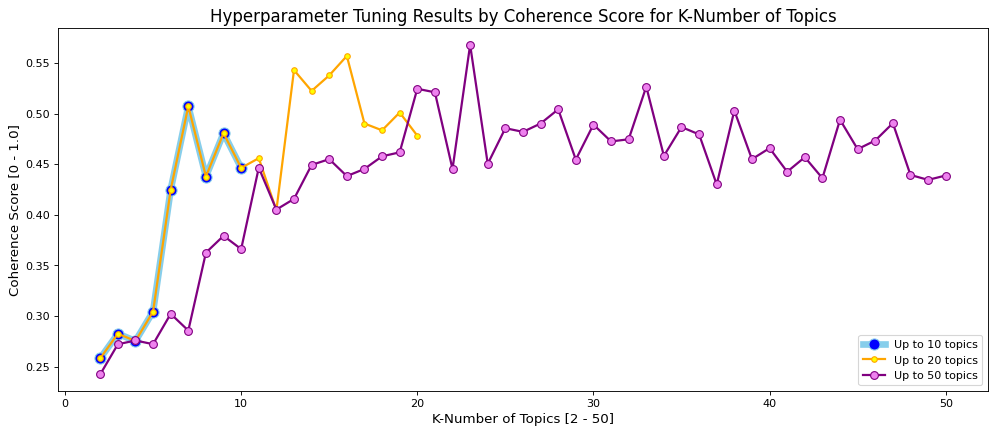

In [42]:
#Set topic as index and transpose to apply seaborn
#param_result_plot = param_result_plot.transpose()

#param_result_plot = param_result_plot.set_index('K-Num Topics').transpose()
#param_result_plot

import matplotlib.pyplot as plt
import seaborn as sns

# multiple line plots
plt.figure(figsize=(15, 6), dpi=80)
plt.plot('K-Num Topics', 'Coherence_10', data= param_result_plot, marker='o', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=6, label="Up to 10 topics")
plt.plot('K-Num Topics', 'Coherence_20', data= param_result_plot, marker='o', markerfacecolor='yellow', markersize=5, color='orange', linewidth=2, label="Up to 20 topics")
plt.plot('K-Num Topics', 'Coherence_50', data= param_result_plot, marker='o', markerfacecolor='violet', markersize=7, color='purple', linewidth=2, label="Up to 50 topics")
# show legend
plt.legend(loc='lower right')
plt.xlabel("K-Number of Topics [2 - 50]", fontsize=12)
plt.ylabel("Coherence Score [0 - 1.0]", fontsize=12)
plt.title("Hyperparameter Tuning Results by Coherence Score for K-Number of Topics", fontsize=15)

# save the figure
plt.savefig('hyperparameter_tuning_plot.png')

# show graph
plt.show()

In [43]:
# If you want to view the resuklt in a easier way
param_result_plot_mod = param_result_plot.transpose()
param_result_plot_mod

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
K-Num Topics,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.00000,28.000000,29.000000,30.000000,31.00000,32.00000,33.000000,34.000000,35.000000,36.000000,37.000000,38.000000,39.000000,40.000000,41.000000,42.000000,43.000000,44.000000,45.000000,46.000000,47.000000,48.00000,49.000000,50.000000
Coherence_10,0.258336,0.282604,0.275386,0.304517,0.424928,0.507301,0.437830,0.480604,0.446346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Coherence_20,0.258336,0.282604,0.275386,0.304517,0.424928,0.507301,0.437830,0.480604,0.446346,0.455939,0.404407,0.542928,0.522373,0.537681,0.556886,0.490184,0.483437,0.501048,0.478189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Coherence_50,0.242514,0.272186,0.275918,0.272249,0.302235,0.285694,0.362674,0.379264,0.366147,0.446488,0.405199,0.415720,0.449258,0.454980,0.438235,0.445331,0.457780,0.461703,0.524489,0.520978,0.445213,0.567858,0.450332,0.485568,0.481925,0.49016,0.504182,0.454553,0.489104,0.47248,0.47459,0.526549,0.458183,0.486695,0.479406,0.429952,0.502944,0.454941,0.465851,0.442542,0.456924,0.436187,0.493909,0.464835,0.473389,0.490491,0.43938,0.434524,0.438831


** **
#### Step 7: Final Model
** **

Based on external evaluation (Code to be added from Excel based analysis), let's train the final model with parameters yielding highest coherence score

In [44]:
num_topics = 16

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.91,
                                           eta=0.91)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [45]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"game" + 0.005*"say" + 0.003*"use" + 0.003*"market" + 0.003*"people" '
  '+ 0.003*"look" + 0.003*"could" + 0.003*"screen" + 0.002*"learn" + '
  '0.002*"way"'),
 (1,
  '0.000*"say" + 0.000*"year" + 0.000*"last" + 0.000*"list" + 0.000*"music" + '
  '0.000*"game" + 0.000*"people" + 0.000*"make" + 0.000*"take" + '
  '0.000*"would"'),
 (2,
  '0.007*"say" + 0.005*"make" + 0.005*"get" + 0.004*"first" + 0.004*"work" + '
  '0.003*"play" + 0.003*"phone" + 0.003*"game" + 0.003*"would" + '
  '0.003*"minute"'),
 (3,
  '0.000*"say" + 0.000*"year" + 0.000*"make" + 0.000*"would" + 0.000*"last" + '
  '0.000*"also" + 0.000*"take" + 0.000*"first" + 0.000*"work" + 0.000*"go"'),
 (4,
  '0.002*"voter" + 0.002*"registration" + 0.002*"mail" + 0.002*"say" + '
  '0.002*"virus" + 0.002*"fraud" + 0.002*"electoral" + 0.001*"recipient" + '
  '0.001*"attachment" + 0.001*"observer"'),
 (5,
  '0.002*"test" + 0.002*"season" + 0.001*"charge" + 0.001*"drug" + '
  '0.001*"dope" + 0.001*"competition" + 0.001*

In [46]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3579984344504925
